# Classification sur jeux de données déséquilibré

A dataset which contain some customers who are withdrawing their account from the bank due to some loss and other issues.

**Variables**
- RowNumber:
- CustomerId:
- Surname: Surname of relevant customer
- CreditScore: It changes 350-850 in the dataset, express credit eligibility
- Geography: There are 3 country in the dataset, show county where Customer live in.
- Gender: Customer Gender
- Age: Customer Age
- Tenure: How many years customer work with this bank
- Balance: Customer's total money in the account
- NumOfProducts: Product number customer use
- HasCrCard: Whether has credit card or not (Customer has credit card is 1)
- IsActiveMember: Customer is active or not
- EstimatedSalary: Customers salary (yearly)
- Exited: Churn or not (Churn situation is 1)

**Imports**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import BalancedRandomForestClassifier

**Data**

In [2]:
df = pd.read_csv('Churn Modeling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [4]:
to_drop = ['RowNumber', 'CustomerId', 'Surname']
df.drop(to_drop, axis = 1, inplace = True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


Very clean data ! No Nan !

**EDA**

- Variables catégorielles

In [6]:
# Variables uniquement catégorielles ou variables de type numérique mais cardinales :
cat_cols = [col for col in df.columns if df[col].dtypes == "O" or (df[col].nunique() < 10 and df[col].dtypes != "O")]
cat_cols

['Geography',
 'Gender',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'Exited']

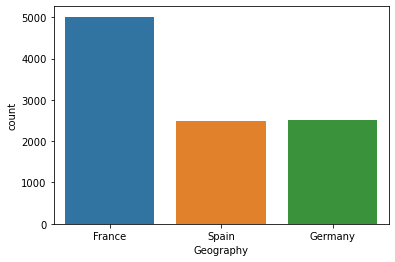

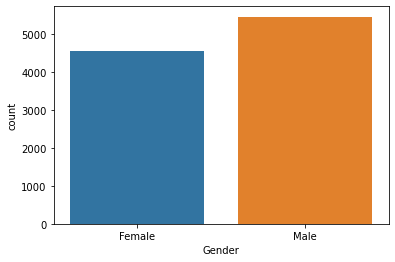

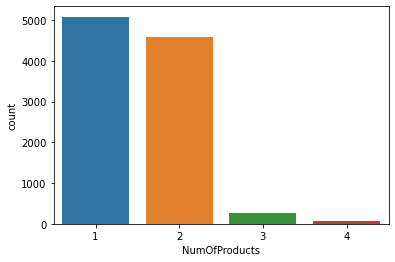

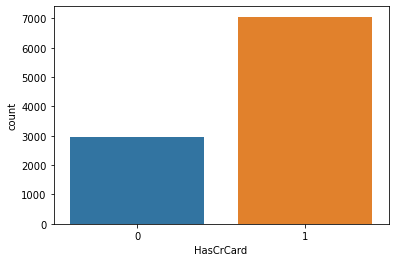

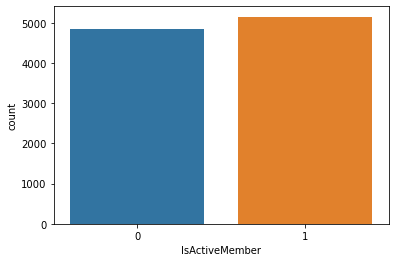

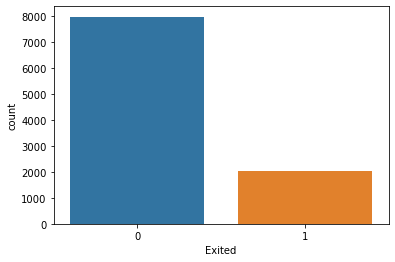

In [7]:
for col in cat_cols:
    sns.countplot(x = col, data = df);
    plt.show()

In [8]:
df['Exited'].value_counts(normalize = True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

- La plupart des clients viennent de France et le nombre de clients qui vivent en Allemagne et en Espagne sont proches.
- Très peu de clients ont 3 ou 4 produits.
- La plupart des clients ont une carte de crédit.
- 20.37% des clients ont résilié leur compte. -> Le modèle devra avoir un score supérieur à 0.7963 !

- Variables numériques

In [9]:
num_cols = [col for col in df.columns if df[col].dtypes != "O" and col not in cat_cols]
num_cols

['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

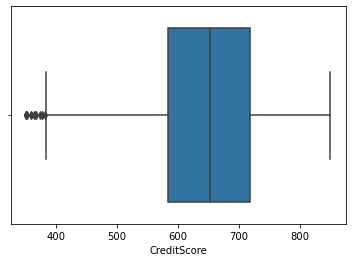

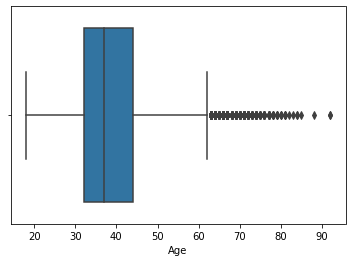

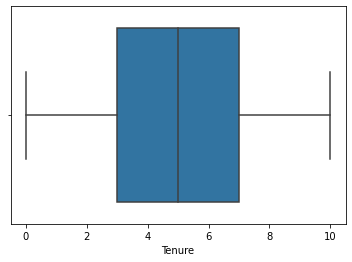

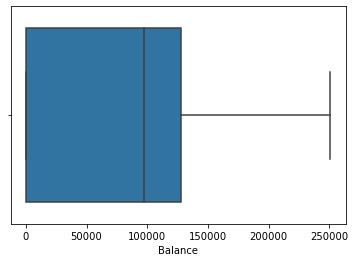

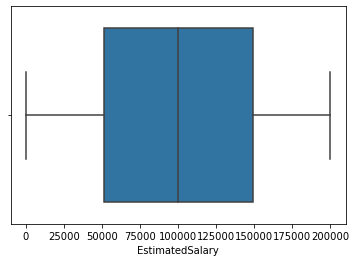

In [10]:
for col in num_cols:
    sns.boxplot(x=df[col]);
    plt.show()

Il ne semble pas y avoir d'outliers

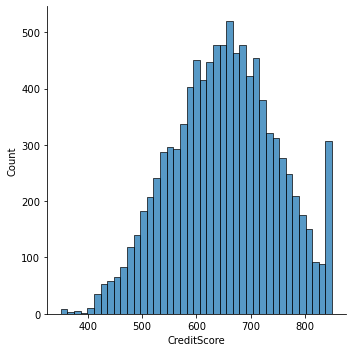

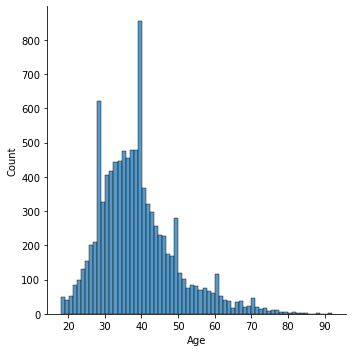

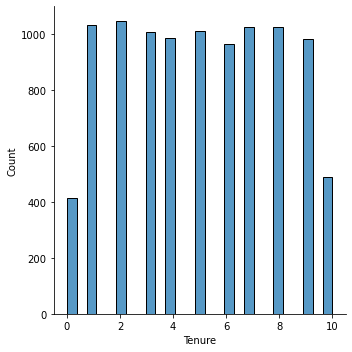

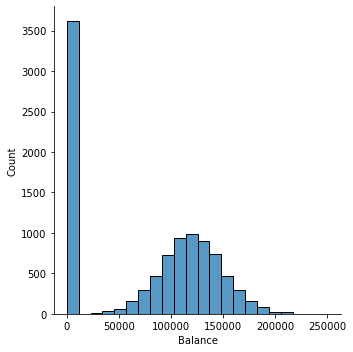

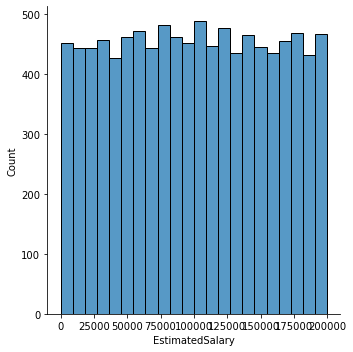

In [11]:
for col in num_cols:
    sns.displot(x=df[col]);
    plt.show()

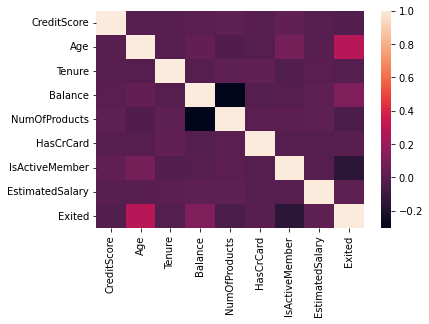

In [12]:
# Corrélations
sns.heatmap(df.corr());

Les variables sont très peu corrélées entre elles

**Preprocessing**

In [13]:
# Split
X = df.drop('Exited', axis = 1)
y = df['Exited']

In [14]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [15]:
# Encodage des variables catégorielles
cat_cols.remove('Exited')
for col in cat_cols:
      X = pd.get_dummies(X, columns=[col], drop_first=True)

X.head()

,CreditScore,Age,Tenure,Balance,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,HasCrCard_1,IsActiveMember_1
0,619,42,2,0.00,101348.88,0,0,0,0,0,0,1,1
1,608,41,1,83807.86,112542.58,0,1,0,0,0,0,0,1
2,502,42,8,159660.80,113931.57,0,0,0,0,1,0,1,0
3,699,39,1,0.00,93826.63,0,0,0,1,0,0,0,0
4,850,43,2,125510.82,79084.10,0,1,0,0,0,0,1,1


In [16]:
# Train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [17]:
# Standardisation
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Oversampling et modélisation**

- RandomOverSampler

In [18]:
rOs = RandomOverSampler()
X_ro, y_ro = rOs.fit_resample(X_train, y_train)
y_ro.value_counts() # Pour vérifier

0    6356
1    6356
Name: Exited, dtype: int64

- SVM model

In [19]:
svm = SVC(gamma = 'scale')
svm.fit(X_ro, y_ro)
y_pred = svm.predict(X_test)

In [20]:
pd.crosstab(y_test, y_pred)

col_0,0,1
Exited,,
0,1269,338
1,98,295


In [21]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.79      0.75      0.85      0.77      0.60      1607
          1       0.47      0.75      0.79      0.58      0.77      0.59       393

avg / total       0.84      0.78      0.76      0.80      0.77      0.59      2000



- BalancedRandomForestClassifier

In [22]:
brf = BalancedRandomForestClassifier()
brf.fit(X_train, y_train)
y_pred_b = brf.predict(X_test)

In [23]:
pd.crosstab(y_test, y_pred_b)

col_0,0,1
Exited,,
0,1284,323
1,89,304


In [24]:
print(classification_report_imbalanced(y_test, y_pred_b))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.80      0.77      0.86      0.79      0.62      1607
          1       0.48      0.77      0.80      0.60      0.79      0.62       393

avg / total       0.85      0.79      0.78      0.81      0.79      0.62      2000



Le score est meilleur sur la classe 1 (churn)

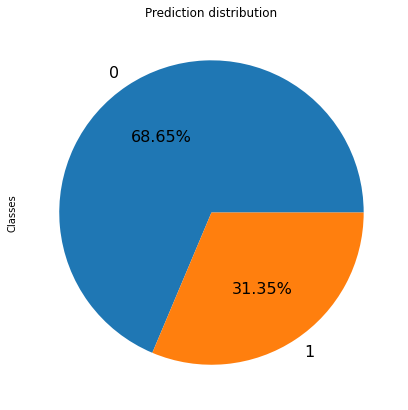

In [25]:
# Distribution des prédictions :
df_pred = pd.DataFrame(data = {'Classes' : y_pred_b})
plt.figure(figsize=(7,7))
df_pred['Classes'].value_counts().plot.pie(autopct='%1.2f%%', textprops={'fontsize':16}).set_title("Prediction distribution");